# Building a cloud based pasture prediction stack
An example for GEOM3001 by Peter Scarth

This session outlines a cloud-based workflow for building a total standing dry matter (TSDM) prediction model by calibrating field data to coincident Sentinel 2 imagery and then training a machine learning model to predict across the landscape.

It is a simplified version of the prediction and delivery method used by the startup company [Cibo Labs](https://www.cibolabs.com.au/pasturekey).

Being able to work using data sets on the cloud has a number of benefits.
 - Having the compute next to the imagery makes operations fast
 - Having access to fast data science platforms like [SageMaker](https://aws.amazon.com/sagemaker/) or [Google Colaboratory](https://research.google.com/colaboratory/) makes running experiments fast
 - Having access to scalable compute and free data makes the starting cost very low, and allows you to grow as your customer base grows

## The first step is to import all the python libraries we'll need
If you're new to this, I'd recommend starting with [Miniconda](https://docs.conda.io/en/latest/miniconda.html) then installing the required packages in a new environment. I'd also recommend replacing conda with [mamba](https://github.com/mamba-org/mamba) to speed up the solving of python dependencies. Something like this should work:
```
conda create --name geom3001 python=3.9
conda activate geom3001 
conda install -c conda-forge mamba
mamba install -c conda-forge boto3 cramjam fastapi folium gcc gdal geopandas imageio jupyterlab matplotlib numexpr numpy pip plotly pystac-client rasterio rust uvicorn tensorflow
pip install titiler.application
```

In [1]:
# IMPORTS

from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import folium
from osgeo import gdal
import rasterio
from imageio.v2 import imread
import tensorflow as tf
from pystac_client import Client


## Organize Field Data

Field data is collected in the field using [Open Data Kit (ODK)](https://getodk.org/)
### Load the data

,transect_id,tsdm,points_center_lat,points_center_lng,sample_date,geometry
0,rqgsioklsvaukfyrtprndywruvjfhesx,1400,-25.673810,151.779993,2020-05-21,POINT (151.77999 -25.67381)
1,pmrrncgczplamiqrffexbsevkfjtcxzy,1335,-25.674966,151.773798,2020-05-21,POINT (151.77380 -25.67497)
2,ehtgxxdmqufrmjcpyvylhqmpfjjypaji,1845,-25.664339,151.771542,2020-05-22,POINT (151.77154 -25.66434)
3,kcfisqqjhujgxothionficnmnfaoofkf,4630,-25.680011,151.768055,2020-05-21,POINT (151.76806 -25.68001)
4,criebpvmarctjkawpdcqqidcxfhvmflr,2150,-25.663473,151.755347,2020-05-21,POINT (151.75535 -25.66347)


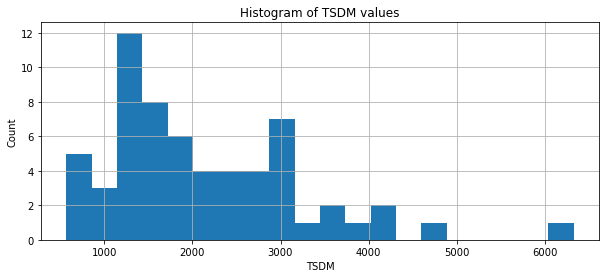

In [2]:

# Read the field data directly from the web without downloading the whole dataset
FIELD_DATA = '/vsicurl/https://github.com/petescarth/GEOM3001-7001/raw/main/odkFieldData.fgb'

# Load the field data into a geopandas dataframe
fieldData = gp.read_file(FIELD_DATA)
# Plot a histogram of the TSDM values to check the data range
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.hist(fieldData.tsdm, bins=20);
ax.set_ylabel('Count')
ax.set_xlabel('TSDM')
ax.set_title('Histogram of TSDM values')
ax.grid()
# Print the header
fieldData.head()

### Plot the data using Matplotlib on the Dataframe

<AxesSubplot:>

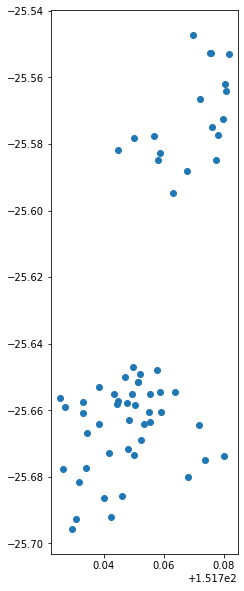

In [4]:
# Plot the dataframe using matplotlib
fieldData.plot(figsize=(10,10))

### Show the sites on a better map

In [5]:
# Plot the dataframe using folium
map = folium.Map(
    location = [fieldData.points_center_lat.mean(),fieldData.points_center_lng.mean()],
     tiles = "OpenStreetMap", zoom_start = 12)

folium.features.GeoJson(
    fieldData[['geometry','tsdm']].to_json(),
     tooltip=folium.GeoJsonTooltip(fields=['tsdm'])
     ).add_to(map)

map

## Select the best Sentinel 2 image from AWS

To do this we first filter using the dates and bounds of the field data, and then select the tile with the lowest cloud.

#### Create the time range and bounding box for the search

In [6]:
bufferDate = 5 # days buffer around field work

# Work out the date range of the field data
earliestImageDate = (fieldData.sample_date.min() - timedelta(days=5)).strftime("%Y-%m-%d")
latestImageDate = (fieldData.sample_date.max() + timedelta(days=5)).strftime("%Y-%m-%d")
timeRange = f"{earliestImageDate}/{latestImageDate}"

# Work out the bounding box of the field data
bbox = fieldData.total_bounds
print(f'Will search for imagery between {earliestImageDate} and {latestImageDate} using a bounding box of\n{bbox}')

Will search for imagery between 2020-05-14 and 2020-06-01 using a bounding box of
[151.7252935 -25.695717  151.7817585 -25.5472235]


#### Now search the STAC catalog
Here we use PySTAC, a library for working with [SpatioTemporal Asset Catalogs](https://stacspec.org) (STAC).

In [7]:
# Search the Element84 STAC catalog
client = Client.open("https://earth-search.aws.element84.com/v0")
s2Search = client.search(
    collections=['sentinel-s2-l2a-cogs'],# or sentinel-s2-l2a
    datetime = timeRange,
    bbox=bbox
    )

# Show the results of the search
print(f"{s2Search.matched()} items found:\n{list(s2Search.items())}")


4 items found:
[<Item id=S2A_56JLS_20200529_0_L2A>, <Item id=S2B_56JLS_20200524_0_L2A>, <Item id=S2A_56JLS_20200519_0_L2A>, <Item id=S2B_56JLS_20200514_0_L2A>]


#### Show thumbnails and some information on the found Sentinel 2 Tiles
The logic here is to look through each "page" of results, look at the items in each page, and keep track of the item with the lowest cloud for further analysis

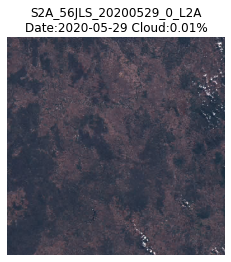

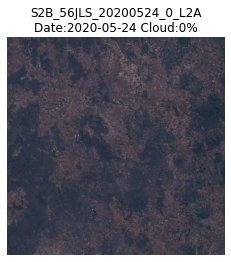

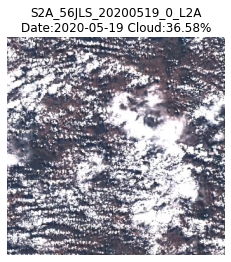

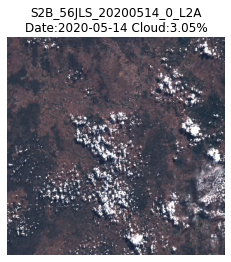

S2B_56JLS_20200524_0_L2A had the lowest cloud cover of 0%


In [9]:

# Also, find the lowest cloud cover tile
lowestCloudCover = 101
bestItem = None


# Loop for each page of results
for page in s2Search.item_collections():
    # Loop for each item in a page
    for item in page:
        # Get the cloudamount from the item
        cloudAmount = item.properties['eo:cloud_cover']
        if cloudAmount < lowestCloudCover:
            lowestCloudCover = cloudAmount
            bestItem = item
        # Read the thumbnail
        thumbnail = imread(item.assets["thumbnail"].href);
        # Show the thumbnail - This sometimes times out on slow connections
        plt.imshow(thumbnail)
        # Add some metadata as the title
        dateString = item.get_datetime().strftime('%Y-%m-%d')
        plt.title(f"{item.id}{chr(10)}Date:{dateString} Cloud:{cloudAmount}%")
        plt.axis('off')
        # Notebook Trick: pause allows the notebook to render the plot
        plt.pause(1)

print(f"{bestItem.id} had the lowest cloud cover of {lowestCloudCover}%")

## Build a GDAL VRT file to access the Sentinel 2 data directly from AWS
There are a few ways of doing this, but the key is using GDAL's [virtual filesystem support](https://gdal.org/user/virtual_file_systems.html)

I personally like GDAL's [Virtual format (VRT)](https://gdal.org/drivers/raster/vrt.html) method as I can control resampling, output resolution, band ordering etc.

And I like being able to access one Sentinel Tile as one file so I stack all the individual bands.


In [10]:
# Define a function to build a Virtual Raster from a STAC item
# Returns the VRT filename that is stored in the notebook directory
# This can take a little while to run as GDAL needs to open each band before making the VRT
def makeS2VRTFromItem(item):
    # List of the band names we're looking for
    s2BandNames = ['B02','B03','B04','B05','B06','B07','B08','B11','B12']
    # List to hold the individual bands
    urlList = []
    # Loop for each bandname
    for band in s2BandNames:
        # Get the url for the band
        url = item.assets[band].href
        print(url)
        # Add it to the list
        urlList.append('/vsicurl/' + url)
    vrtName = item.id+'.vrt'
    # Build the VRT
    vrtOptions = gdal.BuildVRTOptions(resampleAlg='average', 
                                        separate=True,
                                        resolution='lowest',
                                        )
    vrtData = gdal.BuildVRT(vrtName, urlList, options = vrtOptions)
    vrtData = None
    return vrtName


# Make a 40m spatial resolution VRT for the best Tile
vrtName = makeS2VRTFromItem(bestItem)
print(f'Made: {vrtName}')

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B02.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B03.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B05.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B06.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B07.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B08.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B11.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentine

### Waht is a VRT??

In [11]:
!gdalinfo {vrtName}

Driver: VRT/Virtual Raster
Files: S2B_56JLS_20200524_0_L2A.vrt
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B02.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B03.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B04.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B05.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B06.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B07.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B08.tif

### Access the Sentinel Data through the VRT
One of the cool things about [Cloud Optimized GeoTIFFs(https://www.cogeo.org/)] is that if you request a reduced spatial resolution it will read from the file overviews. This keeps data transfers low.

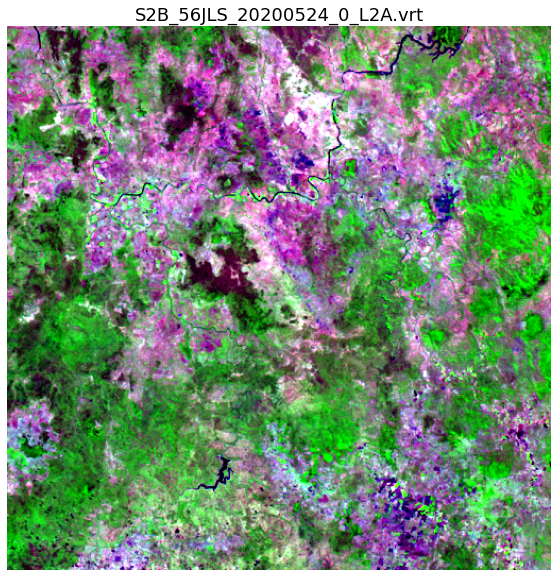

In [12]:
# Function to plot a band combination using a 2:98% Stretch
bandList = [8,7,3]
# Open the VRT
cloudRaster = rasterio.open(vrtName )
# Get the data for the bands we want using a decimated read
falseColourThumbnail = cloudRaster.read(bandList,out_shape=(3, 512, 512))
# Change the ordering for matplotlib
falseColourThumbnail = np.rollaxis(falseColourThumbnail,0,3)
# Scale the data using a 2:98% stretch
scaleStats = np.percentile(falseColourThumbnail,[2,98],axis=(0,1))
falseColourThumbnail = (falseColourThumbnail - scaleStats[0]) / (scaleStats[1] - scaleStats[0])
falseColourThumbnail = np.clip(falseColourThumbnail * 255,0,255).astype(np.uint8)
# Plot the data
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(falseColourThumbnail,aspect=1)
ax.set_title(vrtName, fontsize=18)
ax.axis('off');


## Link the field TSDM data to the image

In [13]:
cloudRaster = rasterio.open(vrtName)
# Reproject the geometry to match the raster
fieldProjectedGeometry = fieldData.geometry.to_crs(cloudRaster.crs)
# Build a list of coordinate pairs to pass to Rasterio's sample function
coordList = [(x,y) for x,y in zip(fieldProjectedGeometry.x , fieldProjectedGeometry.y)]
# Sample the raster without downloading it and add it to the dataframe
fieldData['Sentinel2'] = [x for x in cloudRaster.sample(coordList)]
# Show what the fielddata looks like now
fieldData.head()


,transect_id,tsdm,points_center_lat,points_center_lng,sample_date,geometry,Sentinel2
0,rqgsioklsvaukfyrtprndywruvjfhesx,1400,-25.673810,151.779993,2020-05-21,POINT (151.77999 -25.67381),"[460, 641, 820, 1223, 1654, 1816, 2035, 2701, ..."
1,pmrrncgczplamiqrffexbsevkfjtcxzy,1335,-25.674966,151.773798,2020-05-21,POINT (151.77380 -25.67497),"[473, 636, 955, 1220, 1444, 1625, 1869, 3115, ..."
2,ehtgxxdmqufrmjcpyvylhqmpfjjypaji,1845,-25.664339,151.771542,2020-05-22,POINT (151.77154 -25.66434),"[271, 418, 485, 864, 1461, 1672, 1817, 1903, 1..."
3,kcfisqqjhujgxothionficnmnfaoofkf,4630,-25.680011,151.768055,2020-05-21,POINT (151.76806 -25.68001),"[462, 648, 1008, 1215, 1508, 1665, 1987, 2563,..."
4,criebpvmarctjkawpdcqqidcxfhvmflr,2150,-25.663473,151.755347,2020-05-21,POINT (151.75535 -25.66347),"[403, 580, 751, 1087, 1446, 1599, 1793, 2614, ..."


## Build a Tensorflow Multi Layer Perceptron model to predict Total Standing Dry Matter
We define and train a very simple [MLP Model](https://en.wikipedia.org/wiki/Multilayer_perceptron) in Tensorflow.

 - We scale the data into the 0-1 range
 - Use the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) function due to it's robustness to outliers from  dodgy field data
 - Use the [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) optimiser
 - Train it for 600 iterations, keeping 33% of the data for validation
 - Plot the training and validation losses

The model architecture is represented in the diagram below.

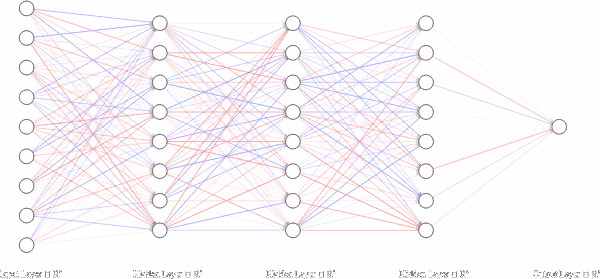


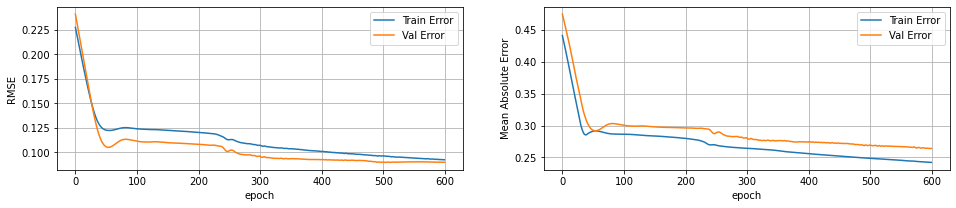

In [15]:
# Shuffle the data
fieldData.sample()
# Extract X and y data from the dataframe
X = np.array(fieldData['Sentinel2'].to_list(),dtype=np.float32)
y = np.array(fieldData['tsdm'],dtype=np.float32)
# Scale the data from 0 to 1
X = X / 10000 # Scale to reflectance
y = y / 10000 # Scale to t/Ha/10 



tsdmMLP = tf.keras.Sequential([
tf.keras.layers.Dense(8, activation='relu', input_shape=[X.shape[1]]),
tf.keras.layers.Dense(8, activation='relu'),
tf.keras.layers.Dense(8, activation='relu',),
tf.keras.layers.Dense(1)
])

tsdmMLP.compile(loss=tf.keras.losses.Huber(delta = 0.05),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['mean_absolute_error', 'mean_squared_error','mean_absolute_percentage_error'])

history = tsdmMLP.fit(X,y, epochs = 600,
                    validation_split = 0.33,
                    shuffle = True,
                    batch_size = 8192,
                    verbose=0)


# Make a plot of the training run
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,3))

ax1.plot(history.epoch, np.sqrt(history.history['mean_squared_error']),label='Train Error')
ax1.plot(history.epoch, np.sqrt(history.history['val_mean_squared_error']),label = 'Val Error')
ax1.set_xlabel('epoch')
ax1.set_ylabel('RMSE')
ax1.grid()
ax1.legend()

ax2.plot(history.epoch, np.sqrt(history.history['mean_absolute_error']),label='Train Error')
ax2.plot(history.epoch, np.sqrt(history.history['val_mean_absolute_error']),label = 'Val Error')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.grid()
ax2.legend()






## Use the Tensorflow model to predict on the full data set
Accessing the image from the cloud and writing locally

In [36]:

# The prediction function
def predictTsdm(nbar, tsdmMLP):
    # Get the shape of the input array
    inshape = nbar.shape
    # Flatten and scale reflectance
    nbar = np.reshape(nbar,(inshape[0],-1)) / 10000.0
    # Run the prediction
    tsdm = tsdmMLP.predict(nbar.T,batch_size=262144)
    # Clip Output from 1 to 10000 kg/Ha
    tsdm = np.clip(np.round(tsdm * 10000),1,10000)
    # Make Nodata values 0
    tsdm[nbar[0] ==0 ] = 0
    tsdm[nbar[0] > 1] = 0
    # Reshape the output back to the original shape
    return np.reshape(tsdm,(1,inshape[1],inshape[2])).astype(np.uint16)

# Make a filename for the prediction
tsdmImageName = vrtName.replace('.vrt','_tsdm.tif')

# Apply the prediction function to the raster
with rasterio.open(vrtName) as src:
    kwargs = src.meta
    kwargs['driver']='GTIFF'
    kwargs['count']=1
    kwargs['nodata']=0
    kwargs['dtype']='uint16'
    # Tiling iterator
    tiles = src.block_windows(0)
    # Loop through the tiles
    with rasterio.open(tsdmImageName, 'w', **kwargs,
                         compress="DEFLATE",
                         tiled=True, 
                         blockxsize=256, 
                         blockysize=256) as dst:
        for idx, window in tiles:
            srcData = src.read(window=window).astype(np.float32)
            dstData = predictTsdm(srcData,tsdmMLP) # Do the Processing Here
            dst.write(dstData, window=window)
        # Build overviews
        dst.build_overviews([2, 4, 8, 16])



### Plot the TSDM image

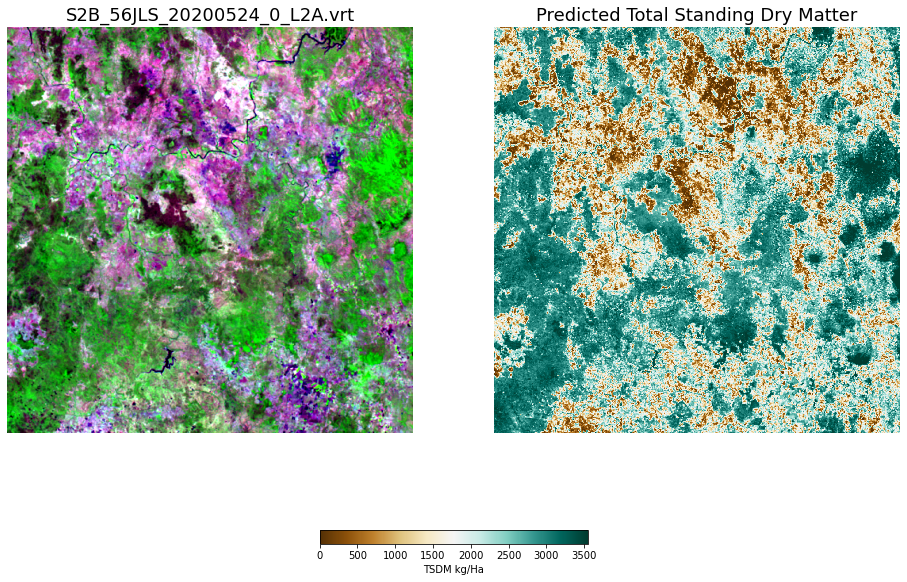

In [17]:
# Make a filename for the prediction
tsdmImageName = vrtName.replace('.vrt','_tsdm.tif')




# Load the Sentinel 2 data into an array ready to plot
cloudRaster = rasterio.open(vrtName )
# Get the data for the bands we want using a decimated read
falseColourThumbnail = cloudRaster.read([8,7,3],out_shape=(3, 512, 512))
# Change the ordering for matplotlib
falseColourThumbnail = np.rollaxis(falseColourThumbnail,0,3)
# Scale the data using a 2:98% stretch
scaleStats = np.percentile(falseColourThumbnail,[2,98],axis=(0,1))
falseColourThumbnail = (falseColourThumbnail - scaleStats[0]) / (scaleStats[1] - scaleStats[0])
falseColourThumbnail = np.clip(falseColourThumbnail * 255,0,255).astype(np.uint8)

# Load the TSDM raster intoan array ready to plot
tsdmRaster = rasterio.open(tsdmImageName)
# Get the data for the bands using a decimated read
tsdmThumbnail = tsdmRaster.read(1,out_shape=(1, 512, 512))
# Scale the data using a 2:98% stretch
scaleStats = np.percentile(tsdmThumbnail,[2,98],axis=(0,1))
tsdmThumbnail = (tsdmThumbnail - scaleStats[0]) / (scaleStats[1] - scaleStats[0])
tsdmThumbnail = np.clip(tsdmThumbnail,0,1) * scaleStats[1]


# Plot the image and prediction side by side with a legend
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,12))
# Sentinel 2 Image
ax1.imshow(falseColourThumbnail,aspect=1)
ax1.set_title(vrtName, fontsize=18)
ax1.axis('off');
# TSDM prediction
im = ax2.imshow(tsdmThumbnail,aspect=1,cmap='BrBG')
ax2.set_title('Predicted Total Standing Dry Matter', fontsize=18)
ax2.axis('off');
# Legend
cbar = fig.colorbar(im, ax=[ax1,ax2],location='bottom', shrink=0.3)
cbar.set_label('TSDM kg/Ha')



## Make the result available as a web service

In [18]:
# Start a local web server in the background to serve the images
# For me in VS Code this is at http://127.0.0.1:5500/S2B_56JLS_20200524_0_L2A_tsdm.tif

# Then run TiTiler to generate a web map
!uvicorn titiler.application.main:app
# Open the web browser to the local server at http://127.0.0.1:8000/cog/viewer



INFO:     Started server process [22530]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     127.0.0.1:59886 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:59886 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:59888 - "GET /cog/viewer HTTP/1.1" 200 OK
INFO:     127.0.0.1:59894 - "GET /cog/info?url=http://127.0.0.1:5500/S2B_56JLS_20200524_0_L2A_tsdm.tif HTTP/1.1" 200 OK
INFO:     127.0.0.1:59894 - "GET /cog/tilejson.json?url=http://127.0.0.1:5500/S2B_56JLS_20200524_0_L2A_tsdm.tif&bidx=1&rescale=0,65535 HTTP/1.1" 200 OK
ERROR 4: `/vsimem/0fc90c00-9e8c-4049-85a2-241f4e466198/0fc90c00-9e8c-4049-85a2-241f4e466198.tif' not recognized as a supported file format.
INFO:     127.0.0.1:59894 - "GET /cog/tiles/WebMercatorQuad/10/943/588%401x?url=http%3A%2F%2F127.0.0.1%3A5500%2FS2B_56JLS_20200524_0_L2A_tsdm.tif&bidx=1&rescale=0%2C65535 HTTP/1.1" 200 OK
ERROR 4: `/vsimem/

## Next Steps
This is only touching the surface of what is possible, but the take home message is that being able to understand the opportunities, or better be ale to  work programmatically in cloud based systems is a great skill to acquire

AWS Batch
Aurora Serverless

Costs
USD$4600 EC2
USD$1600 Aurora